In [ ]:
from google.colab import drive
drive.mount('/content/drive/ESoWC/')

In [ ]:
%cd /content/drive/My Drive/ESoWC

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import random

from sklearn import datasets
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot

/opt/conda/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load dataset and clean

In [23]:
import geopandas as gpd

<xarray.Dataset>
Dimensions:           (latitude: 33, longitude: 33, time: 708)
Coordinates:
  * latitude          (latitude) float64 43.0 43.25 43.5 ... 50.5 50.75 51.0
  * longitude         (longitude) float64 4.0 4.25 4.5 4.75 ... 11.5 11.75 12.0
  * time              (time) datetime64[ns] 2019-05-01T01:00:00 ... 2019-05-3...
Data variables: (12/13)
    NO_tc             (latitude, longitude, time) float64 ...
    CO2_tc            (latitude, longitude, time) float64 ...
    CH4_tc            (latitude, longitude, time) float64 ...
    NO2_tc            (latitude, longitude, time) float64 ...
    CO_tc             (latitude, longitude, time) float64 ...
    O3_tc             (latitude, longitude, time) float64 ...
    ...                ...
    NO_tc_add_trend   (latitude, longitude, time) float64 ...
    CO2_tc_add_trend  (latitude, longitude, time) float64 ...
    CH4_tc_add_trend  (latitude, longitude, time) float64 ...
    NO2_tc_add_trend  (latitude, longitude, time) float64 ...
    CO_tc_add_trend   (latitude, longitude, time) float64 ...
    O3_tc_add_trend   (latitude, longitude, time) float64 ...

In [25]:
import matplotlib.pyplot as plt

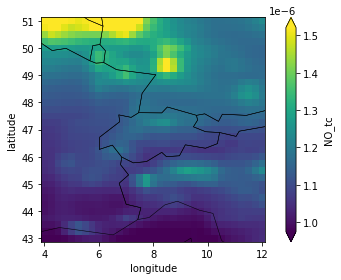

In [39]:
ds.NO_tc.mean('time').plot(robust=True)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
c.plot(ax=ax, fc='None', ec='black', lw=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.tight_layout()

In [44]:
ds = xr.open_dataset('../../data/totalcolConcentretations_featured+Emissions.nc')

In [42]:
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

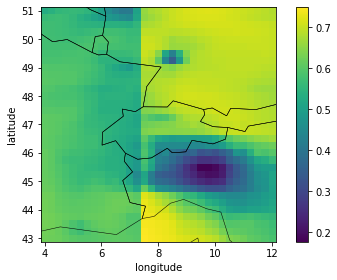

In [43]:
xr.corr(ds.NO_tc, ds.EMISSIONS_2019, dim='time').plot()

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
countries.plot(ax=ax, fc='None', ec='black', lw=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.tight_layout()

In [2]:
dataset = xr.open_dataset('dataset_complete_for_model.nc')
dataset

FileNotFoundError: [Errno 2] No such file or directory: b'/home/vidurmithal/MaLePoM/notebooks/model/dataset_complete_for_model.nc'

In [ ]:
df = dataset.to_dataframe()
df = df.dropna()
df.head()

#Normalizing

In [ ]:
df_flat= df.reset_index()
df_flat.head()

In [ ]:
X = df_flat.drop(columns = ['EMISSIONS_2019'])
y = df_flat['EMISSIONS_2019']

input_variables = X.columns
target_variable = 'EMISSIONS_2019'

seed = 1234

In [ ]:
scaler = MinMaxScaler()
df_sc = scaler.fit_transform(df_flat)

df_norm = pd.DataFrame(df_sc, columns=df_flat.columns)
df_norm.head()

#Baseline performance: Linear regression with 10 fold cross validation

In [ ]:
kfolds = KFold(10,shuffle=True,random_state=seed)

model = linear_model.LinearRegression()
scores = cross_val_score(model, df_norm[input_variables], df_norm[target_variable], cv=kfolds)

print("R2 Mean %.3f StdDev %.3f"%(scores.mean(),scores.std()))

#Reduced variance feature selection

In [ ]:
feature_selection_variance_model = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_selected_features_variance = feature_selection_variance_model.fit_transform(X)

mask = feature_selection_variance_model.get_support() #list of booleans
print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", X.loc[:, mask].columns)
print("      Deleted Features = ", X.loc[:, ~mask].columns)

In [ ]:
variance_model = LinearRegression()
variance_scores = cross_val_score(variance_model, X.loc[:,mask], y, cv=kfolds)
print("Variance Model R2 Mean %.3f StdDev %.3f"%(variance_scores.mean(),variance_scores.std()))

#Principal Component Analysis

In [ ]:
full_pca_model = PCA()
full_fitted_model = full_pca_model.fit(df_norm[input_variables])
full_fitted_model.explained_variance_ratio_

In [ ]:
x_max=len(X.columns)
x_max

In [ ]:
plt.plot(full_fitted_model.explained_variance_ratio_, '--o');
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.xlabel("Feature");
plt.ylabel("Percentage of explained variance");
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.yticks(np.arange(0.0,0.31,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.0,0.31,.1)]);
plt.ylim([0.0,0.31]);

In [ ]:
plt.plot(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.yticks(np.arange(0.4,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.4,1.1,.1)]);
plt.ylim([0.4,1.05]);
plt.plot([0,x_max],[.9,.9],':');
plt.plot([0,x_max],[.8,.8],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");

In [ ]:
feature_selection_pca_model = PCA(n_components=10)
fitted_model = feature_selection_pca_model.fit(df_norm[input_variables])

X_selected_features_pca = fitted_model.transform(df_norm[input_variables])
print("    Explained Variance = %.3f" % fitted_model.explained_variance_ratio_.cumsum()[-1])
print("Reduced data set shape =",X_selected_features_pca.shape)

In [ ]:
pca_model = linear_model.LinearRegression()
pca_scores = cross_val_score(pca_model, X_selected_features_pca, y, cv=kfolds)
pca_scores.mean()
print("PCA Model R2 Mean %.3f StdDev %.3f"%(pca_scores.mean(),pca_scores.std()))

#Random Forest feature importance

In [ ]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(df_norm[input_variables], df_norm[target_variable])
importances = forest.feature_importances_
importances

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_norm[input_variables].shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], df_norm[input_variables].columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_norm[input_variables].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_norm[input_variables].shape[1]), df_norm[input_variables].columns[indices],rotation=90)
plt.xlim([-1, df_norm[input_variables].shape[1]])
plt.show()

#Split train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_norm[input_variables], df_norm[target_variable], test_size=0.20, random_state=42)

#XGboost regressor

In [ ]:
XGBModel = XGBRegressor()
XGBModel.fit(X_train, y_train, verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_test)
MAE = mean_absolute_error(y_test , XGBpredictions)
print('XGBoost validation MAE [s] = ', MAE )

In [ ]:
test_predictions = XGBpredictions

a = plt.axes(aspect='equal')
plt.scatter(y_test.values.tolist(), test_predictions.tolist())
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.plot()

In [ ]:
pyplot.plot(y_test.values.tolist(), label='Expected')
pyplot.plot(test_predictions.tolist(), label='Predicted')
pyplot.legend()
pyplot.show()